In [37]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 300
from mpl_toolkits import mplot3d
import numpy as np
import math

torch.set_printoptions(precision=4)

### A linear Poisson equation
$\nabla^2 u = sin(\pi x) sin(\pi y)$ \
$0 \leq x \leq 1$ \
$0 \leq y \leq 1$

### Problem specific functions / variables

In [2]:
# partial differential equation
def f(x):
    return torch.sin(torch.tensor(math.pi)*x[:,0]) * torch.sin(torch.tensor(math.pi)*x[:,1])

def L(model, x):
    y = model(x.float())
    y_x = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y),
    retain_graph=True,
    create_graph=True,
    allow_unused=True)[0]

    y_xx = torch.autograd.grad(y_x, x, grad_outputs=torch.ones_like(y_x),
    retain_graph=True,
    create_graph=True,
    allow_unused=True)[0]

    return torch.sum(y_xx, -1)

# boundary conditions
def g(x):
    return torch.zeros(x.size()[0])

def B(model, x):
    return model(x.float())[:,0]

In [3]:
# Grid point selection
N = 20
def quadU():
    xs = torch.linspace(0, 1, steps=N, requires_grad=True)
    ys = torch.linspace(0, 1, steps=N, requires_grad=True)
    x,y = torch.meshgrid(xs, ys)
    w = torch.cat((torch.reshape(x, (1,-1)), torch.reshape(y,(1,-1))), 0).T

    dw = []
    for xy in w:
        if xy[0] == 0 or xy[1] == 0 or xy[0] == 1 or xy[1] == 1:
            dw.append(xy)
    dw = torch.stack(dw)

    return w, dw

w, dw = quadU()

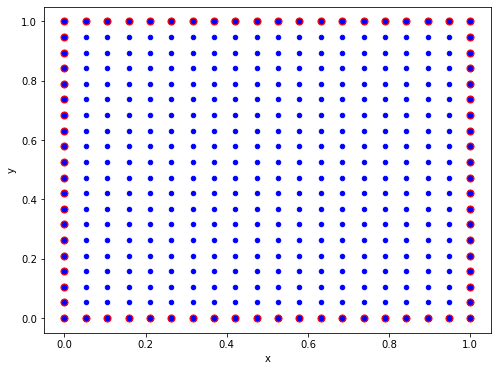

In [4]:
xs_plt = w[:,0].detach().numpy()
ys_plt = w[:,1].detach().numpy()

dxs_plt = dw[:,0].detach().numpy()
dys_plt = dw[:,1].detach().numpy()

fig = plt.figure(figsize =(8, 6))
ax = plt.axes()

ax.scatter(dxs_plt,dys_plt, c = 'r', s = 50)
ax.scatter(xs_plt,ys_plt, c = 'b', s = 20)
ax.set(xlabel="x", ylabel="y")

plt.savefig('../Figures/quadrature.png')

plt.show()

In [5]:
# MC point selection
def quadMC():
    w = torch.rand((N ** 2, 2), requires_grad=True)
    dw = torch.rand((4 * N, 1))
    fw = torch.cat((torch.ones((2 * N, 1)), torch.zeros(2 * N, 1)))
    dw = torch.cat((dw, fw), -1)
    dw[N:(3 * N), :] = torch.flip(dw[N:(3 * N), :], (1,))
    dw.requires_grad = True
    return w, dw

w_mc, dw_mc = quadMC()

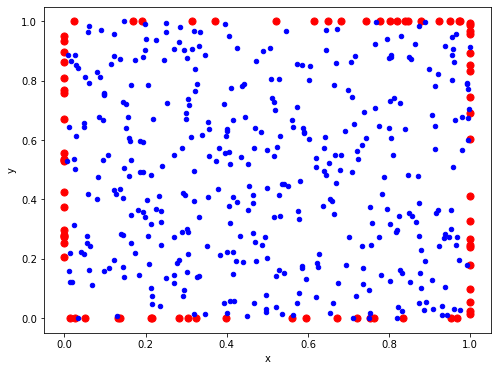

In [6]:
xs_plt_mc = w_mc[:,0].detach().numpy()
ys_plt_mc = w_mc[:,1].detach().numpy()

dxs_plt_mc = dw_mc[:,0].detach().numpy()
dys_plt_mc = dw_mc[:,1].detach().numpy()

fig = plt.figure(figsize = (8, 6))
ax = plt.axes()

ax.scatter(dxs_plt_mc,dys_plt_mc, c = 'r', s = 50)
ax.scatter(xs_plt_mc,ys_plt_mc, c = 'b', s = 20)
ax.set(xlabel="x", ylabel="y")

plt.savefig('../Figures/quadrature_mc.png')

plt.show()

### Loss function

In [7]:
def h(model, w_, dw_):
    df = L(model, w_) - f(w_)
    dg = B(model, dw_) - g(dw_)
    df_loss = torch.sum(torch.square(df)) / (N ** 2)
    dg_loss = torch.sum(torch.square(dg)) / N
    loss = df_loss + dg_loss
    return loss, df_loss, dg_loss

### Neural Networks

In [8]:
class SigFunc(nn.Module):
    def __init__(self,input_size=2,output_size=1):
        super(SigFunc, self).__init__()
        self.linear1 = nn.Linear(input_size,5)
        self.linear2 = nn.Linear(5,5)
        self.linear3 = nn.Linear(5,output_size)

    def forward(self,x):
        z = torch.sigmoid(self.linear1(x))
        z = torch.sigmoid(self.linear2(z))
        z = torch.tanh(self.linear3(z))
        return z

In [9]:
class SinFunc(nn.Module):
    def __init__(self,input_size=2,output_size=1):
        super(SinFunc, self).__init__()
        self.linear1 = nn.Linear(input_size,5)
        self.linear2 = nn.Linear(5,5)
        self.linear3 = nn.Linear(5,output_size)

    def forward(self,x):
        z = torch.sin(self.linear1(x))
        z = torch.sin(self.linear2(z))
        z = torch.sin(self.linear3(z))
        return z

### Training loop

In [10]:
def train_pinn(R, E, modelfn, samplefn):
    losses = torch.zeros((R,3,E))
    models = []
    for r in range(R):
        pdeApprox = modelfn()
        optimizer = torch.optim.Adam(pdeApprox.parameters(), lr=0.001)
        for epoch in range(E):
            #reset gradients
            optimizer.zero_grad()

            # Sample points
            w_, dw_ = samplefn()
            
            #calculate the loss
            loss = h(pdeApprox, w_, dw_)
            losses[r,:,epoch] = torch.tensor(loss)
            
            #backpropagation
            loss[0].backward(retain_graph=True)
            
            #update the parameters
            optimizer.step()
        models.append(pdeApprox)
    return losses, models

In [22]:
runs = 5
epochs = 20000
exp_losses = torch.zeros(4, runs, 3, epochs)
exp_models = []

i = 0
for sample in [quadU, quadMC]:
    for model in [SigFunc, SinFunc]:
        losses, models = train_pinn(runs, epochs, model, sample)
        exp_losses[i] = losses
        exp_models.append(models)
        print(i)
        i += 1

0
1
2
3


In [ ]:
# import data here

In [40]:
# Final loss evaluation

losses_f = exp_losses[:,:,:,-1]
loss_mean = torch.mean(losses_f, 1)
loss_stdev = torch.std(losses_f, 1)
print(loss_mean * 10 ** 3)
print(loss_stdev * 10 ** 3)

tensor([[0.2935, 0.1219, 0.1716],
        [0.1738, 0.0306, 0.1432],
        [3.6745, 2.3659, 1.3086],
        [0.3686, 0.1346, 0.2339]])
tensor([[0.2536, 0.1102, 0.1478],
        [0.0784, 0.0141, 0.0670],
        [1.4632, 0.9365, 0.7502],
        [0.2338, 0.0856, 0.1526]])


In [57]:
# Final score evaluation
def Ne(yh_,yi_):
    return torch.sqrt(torch.abs(torch.sum(torch.pow(yi,2) - torch.pow(yh,2)) / torch.sum(torch.pow(yi,2))))

def analytical(x):
    return - 1 / (2 * torch.tensor(math.pi) ** 2) * torch.sin(torch.tensor(math.pi)*x[:,0]) * torch.sin(torch.tensor(math.pi)*x[:,1])

yi = analytical(w)

Nmse = torch.zeros(4,5)

for i in range(4):
    for j in range(5):
        yh = exp_models[i][j](w)
        Nmse[i][j] = Ne(yh, yi)

Nmse.size()

Nmse_mean = torch.mean(Nmse, -1)
Nmse_stdev = torch.std(Nmse, -1)

print(Nmse_mean)
print(Nmse_stdev)

tensor([18.5612, 17.4254, 21.9892, 16.2527], grad_fn=<MeanBackward1>)
tensor([1.5636, 0.5790, 3.7586, 0.6642], grad_fn=<StdBackward>)
tensor([[17.7615, 21.2900, 17.6821, 17.6061, 18.4663],
        [18.3442, 17.5673, 17.3213, 16.8830, 17.0114],
        [23.4184, 17.4834, 18.5080, 25.7886, 24.7479],
        [16.5676, 16.7313, 15.0864, 16.3809, 16.4972]], grad_fn=<CopySlices>)


In [ ]:
# Basic training curve

losses = 

fig = plt.figure(figsize = (8, 6))
ax = plt.axes()

losses = np.array(losses)
avg = np.average(losses, 0)
stdev = np.std(losses, 0)
labels = ["Loss_total","Loss_df","Loss_dg"]

for i,lab in enumerate(labels):
    ax.plot(avg[i], label=lab)

ax.set(xlabel="Epochs", ylabel="Loss")
ax.set_yscale('log')

ax.legend()
plt.show()

### Neural Network Approximation

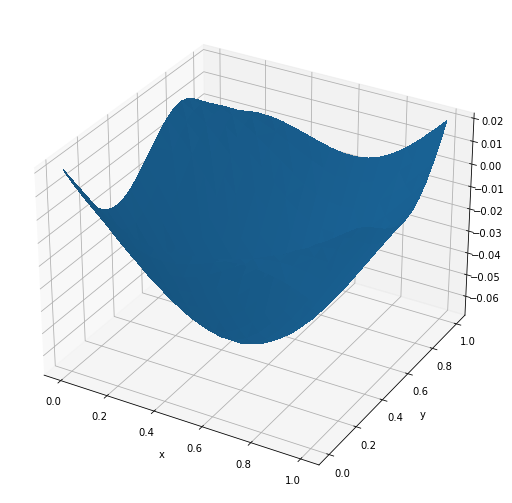

In [64]:
# Creating dataset
pdeApprox = exp_models[3][2]
pred = pdeApprox(w)[:,0].detach().numpy()
 
# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

# Creating plot
surf = ax.plot_trisurf(xs_plt, ys_plt, pred, linewidth=0, antialiased=False)
ax.set(xlabel="x", ylabel="y")

plt.savefig('../Figures/pred.png')

plt.show()

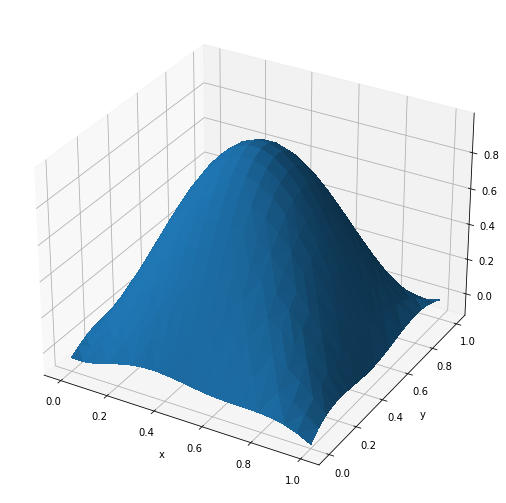

In [62]:
# Creating dataset
grad2 = L(pdeApprox, w).detach().numpy()
 
# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

# Creating plot
surf = ax.plot_trisurf(xs_plt, ys_plt, grad2, linewidth=0, antialiased=False)
ax.set(xlabel="x", ylabel="y")

plt.savefig('../Figures/pred_grad2.png')

plt.show()

### Analytical Solution

In [ ]:
def analytical(x):
    return - 1 / (2 * torch.tensor(math.pi) ** 2) * torch.sin(torch.tensor(math.pi)*x[:,0]) * torch.sin(torch.tensor(math.pi)*x[:,1])

# Creating dataset
solution = analytical(w).detach().numpy()
 
# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

# Creating plot
surf = ax.plot_trisurf(xs_plt, ys_plt, solution, linewidth=0, antialiased=False)
ax.set(xlabel="x", ylabel="y")

plt.savefig('../Figures/analytical_solution.png')

plt.show()

In [ ]:
# Creating dataset
z = f(w)
 
# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

xs_plt = w[:,0].detach().numpy()
ys_plt = w[:,1].detach().numpy()
zs_plt = z.detach().numpy()

# Creating plot
surf = ax.plot_trisurf(xs_plt, ys_plt, zs_plt, linewidth=0, antialiased=False)
ax.set(xlabel="x", ylabel="y")

plt.savefig('../Figures/analytical_grad2.png')

plt.show()

### Low Precision

In [ ]:
import torch
import qtorch
from qtorch import FixedPoint, FloatingPoint
from qtorch.quant import fixed_point_quantize, block_quantize, float_quantize
from qtorch.auto_low import sequential_lower

from torch.optim import Adam
from qtorch.optim import OptimLP;

In [ ]:
forward_num = FixedPoint(wl=4, fl=2)
backward_num = FloatingPoint(exp=5, man=2)
pdeApproxLP = sequential_lower(MyFunction(), layer_types=['linear'],
                            forward_number=forward_num, backward_number=backward_num)

In [ ]:
pdeApproxLP

In [ ]:
optimizer = Adam(pdeApproxLP.parameters(), lr=0.001) # use your favorite optimizer
# define custom quantization functions for different numbers
weight_quant = lambda x : float_quantize(x, exp=5, man=2, rounding="nearest")
gradient_quant = lambda x : float_quantize(x, exp=5, man=2, rounding="nearest")
momentum_quant = lambda x : float_quantize(x, exp=6, man=9, rounding="nearest")
# turn your optimizer into a low precision optimizer
optimizer = OptimLP(optimizer, 
                    weight_quant=weight_quant, 
                    grad_quant=gradient_quant, 
                    momentum_quant=momentum_quant)

In [ ]:
losses = []
#train the neural network for 5 epochs
for epoch in range(20000):
    #reset gradients
    optimizer.zero_grad()
    
    #calculate the loss
    loss = h(pdeApproxLP, w, dw)
    losses.append(np.array(torch.tensor(loss, requires_grad=False)))
    if epoch % 1000 == 0:
        print("Epoch: {e} - Loss: {l:.6f} - Loss (df): {dfl:.6f} - Loss (dg): {dgl:.6f}".format(e=epoch, l=loss[0].item(), dfl=loss[1].item(), dgl=loss[2].item()))
    
    #backpropagation
    loss[0].backward(retain_graph=True)
    
    #update the parameters
    optimizer.step()

In [ ]:
x = w
x = fixed_point_quantize(x, 4, 2)
x.requires_grad=True
x.retain_graph=True
x.create_graph=True
x.allow_unused=True

y = pdeApproxLP(x.float())
y_x = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y),
retain_graph=True,
create_graph=True,
allow_unused=True)[0]

y_xx = torch.autograd.grad(y_x, x, grad_outputs=torch.ones_like(y_x),
retain_graph=True,
create_graph=True,
allow_unused=True)[0]

print(type(y_x))
print(y_xx)